---
format: 
  html:
    toc: false
    page-layout: full
execute:
    echo: True
---

# Final Assignment
## Prediction of Property Saling Price in New York City using sklearn

**Introduction:** to understand the impacts of the selected variables on housing prices in New York City, we first develop a model trained by the historical data of property sale price data in 2020. We include eight independent variables drawn from three different datasets, including total population, total housing units, people in labor force, travel time, median household income, total household, offense description for the area, building class category. To develop the model using historical data, we first split the 2020 sale data into the train and test datasets. We then use GridSearchCV to perform a k-fold cross validation that optimize at least 2 hyperparameters of the Random Forest Regressor. 

#### Writter:
Yuanhao Zhai, Kaye Li

#### Requirement meet: 
- Data is collected through a means more sophisticated than downloading (e.g. scraping, API)
- It combines data collected from 3 or more different sources.
- The analysis of the data is reasonably complex, involving multiple steps (geospatial joins/operations, data shaping, data frame operations, etc).
- You use an osmnx or pandana to perform an analysis of street network data
- You use scikit-learn to perform a clustering analysis.
- You perform a machine learning analysis with scikit-learn as part of the analysis.
- The project includes multiple interactive visualizations that include a significant interactive component (cross-filtering, interactive widgets, etc)

In [3]:
#| echo: true 
#| code-fold: true

#import the essential packages
#base packages
import numpy as np
import pandas as pd
import geopandas as gpd

# Plotting packages
import seaborn as sns
from matplotlib import pyplot as plt
import holoviews as hv
import hvplot.pandas

# Sodapy API packages
import requests
from sodapy import Socrata

# Set a Random Seed
np.random.seed(42)
pd.options.display.max_columns = 999

## Part 1: Collecting Data using API
Data Source: 

[NYC Citywide Annualized Calendar Sales Update](https://data.cityofnewyork.us/resource/w2pb-icbu.json)

[NYC 2020 census tract](https://data.cityofnewyork.us/api/geospatial/63ge-mke6?date=20231219&accessType=DOWNLOAD&method=export&format=GeoJSON)

[NYPD Arrest Data (Year to Date)](https://data.cityofnewyork.us/resource/uip8-fykc.json)

### 1.1 Get the Property Saling data
To get the Property Saling Data from the NYC OpenData, We use the Socrata API to link the database.

In [4]:
#| echo: true 
#| code-fold: true

client = Socrata("data.cityofnewyork.us",
                  "6xHCd7htGtLFFnGXy6R9LdnXB",
                  username="zyuanhao@upenn.edu",
                  password="ZYHtt-0325")

Get the property saling price data from the NYC Open Data using Socrata API.

In [6]:
property_sales = client.get_all("w2pb-icbu")

# Convert to pandas DataFrame
prosal_df = pd.DataFrame.from_records(property_sales)

In [7]:
# clean the raw saling price data, drop all NA data
prosal_clean = prosal_df.drop(columns=['apartment_number','census_tract_2020','nta_code']).dropna()

# convert the str data to float64 data
prosal_clean['sale_price'] = pd.to_numeric(prosal_clean['sale_price'], errors='coerce')
prosal_clean['gross_square_feet'] = prosal_clean['gross_square_feet'].replace(',', '', regex=True)
prosal_clean['gross_square_feet'] = pd.to_numeric(prosal_clean['gross_square_feet'], errors='coerce')

# drop the extreme data(sale price>10000, gross square feet<30)
prosal_filtered = prosal_clean[(prosal_clean['sale_price'] > 10000) & (prosal_clean['gross_square_feet'] > 30)]

# convert df data to geodataframe with crs: 4326
prosal_clean_geo = gpd.GeoDataFrame(
    prosal_filtered, geometry=gpd.points_from_xy(prosal_filtered.longitude, prosal_filtered.latitude), crs="EPSG:4326"
)

To better compare the property price we have to get the sale price per square feet.

In [8]:
prosal_clean_geo['unit_sale_price'] = prosal_clean_geo['sale_price'] / prosal_clean_geo['gross_square_feet']
prosal_clean_geo = prosal_clean_geo.dropna()
prosal_clean_geo.head()

#clean the extrame data
Q1 =  prosal_clean_geo['unit_sale_price'].quantile(0.25)
Q3 =  prosal_clean_geo['unit_sale_price'].quantile(0.75)
IQR = Q3 - Q1

lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
prosal_last_geo = prosal_clean_geo[(prosal_clean_geo['unit_sale_price'] > lower) & (prosal_clean_geo['unit_sale_price'] < upper)]
prosal_last_geo.shape

(162890, 29)

Now, Let's draw a box plot to explore the data

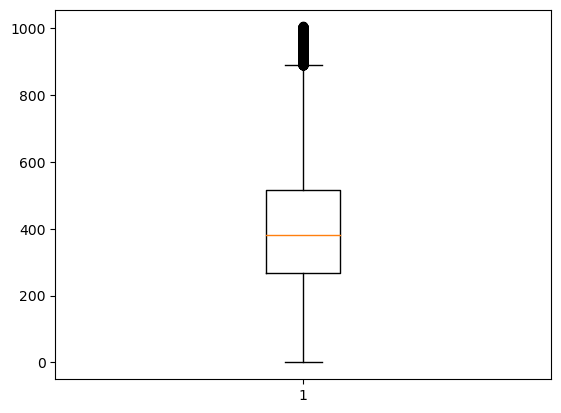

In [9]:
#| echo: true 
#| code-fold: true

# draw a box plot to explore the data
plt.boxplot(prosal_last_geo['unit_sale_price'])
plt.show()

From the plot above, we can see that average price of property is around $400.

And we can also draw a hitogram plot to see the distribution of the data.

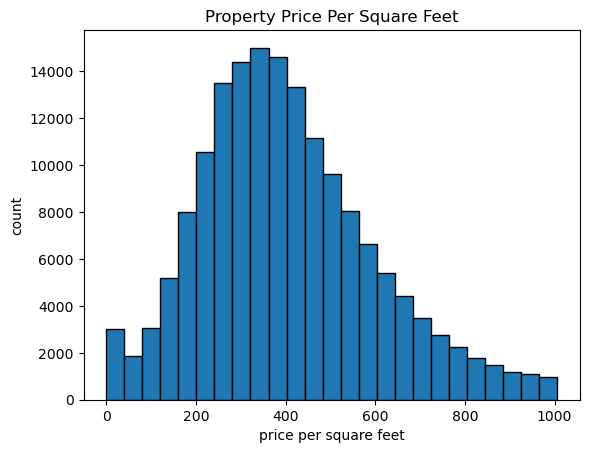

In [10]:
#| echo: true 
#| code-fold: true

plt.hist(prosal_last_geo['unit_sale_price'], bins=25, edgecolor='black')

plt.title('Property Price Per Square Feet')
plt.xlabel('price per square feet')
plt.ylabel('count')

plt.show()

Most of the price is between $200 to $600.

### 1.2 Get the Public Safety Data
To further explain what fator contribute to the property price, we will collect the public safety data by using the NYPD Arrest data, this is a data with the catogory of crime and exact geographic position of crimes. 

In [11]:
# get the NYPD Arrest Data (Year to Date) 
NYPD_arrest = client.get_all("uip8-fykc")

# Convert to pandas DataFrame
public_safe = pd.DataFrame.from_records(NYPD_arrest)

In [12]:
# Convert the dataframe to Geodataframe and drop the NA data.
safe_geo = gpd.GeoDataFrame(
    public_safe, geometry=gpd.points_from_xy(public_safe.longitude, public_safe.latitude), crs="EPSG:4326"
).drop(columns=['geocoded_column']).dropna()
safe_geo.head()

arrest_key              arrest_date pd_cd                      pd_desc  \
0  261209118  2023-01-01T00:00:00.000   109     ASSAULT 2,1,UNCLASSIFIED   
1  262984267  2023-02-03T00:00:00.000   515  CONTROLLED SUBSTANCE,SALE 3   
2  263664549  2023-02-15T00:00:00.000   105            STRANGULATION 1ST   
3  261345231  2023-01-04T00:00:00.000   105            STRANGULATION 1ST   
4  263536618  2023-02-13T00:00:00.000   109     ASSAULT 2,1,UNCLASSIFIED   

  ky_cd        ofns_desc    law_code law_cat_cd arrest_boro arrest_precinct  \
0   106   FELONY ASSAULT  PL 1200501          F           K              77   
1   117  DANGEROUS DRUGS  PL 2203901          F           K              73   
2   106   FELONY ASSAULT  PL 1211200          F           K              62   
3   106   FELONY ASSAULT  PL 1211200          F           M              32   
4   106   FELONY ASSAULT  PL 12005WX          F           K              71   

  jurisdiction_code age_group perp_sex perp_race x_coord_cd y_coord_cd  \
0                 0     45-64        F     BLACK     999335     186085   
1                 0     25-44        M     BLACK    1009318     178259   
2                 0     25-44        M     WHITE     982272     158771   
3                 0     25-44        M     BLACK     999899     238684   
4                 0     25-44        M     BLACK    1001437     183080   

    latitude   longitude :@computed_region_f5dn_yrer  \
0  40.677426  -73.945615                          16   
1  40.655923   -73.90965                          55   
2  40.602468   -74.00712                           1   
3  40.821797  -73.943457                          18   
4  40.669175  -73.938042                          16   

  :@computed_region_yeji_bk3q :@computed_region_92fq_4b7q  \
0                           2                          49   
1                           2                          25   
2                           2                          44   
3                           4                          36   
4                           2                          48   

  :@computed_region_sbqj_enih :@computed_region_efsh_h5xi  \
0                          49                       17618   
1                          46                       17614   
2                          37                       17616   
3                          20                       12427   
4                          49                       17615   

                     geometry  
0  POINT (-73.94562 40.67743)  
1  POINT (-73.90965 40.65592)  
2  POINT (-74.00712 40.60247)  
3  POINT (-73.94346 40.82180)  
4  POINT (-73.93804 40.66918)

(array([6.0572e+04, 4.7617e+04, 1.4415e+04, 1.5298e+04, 1.8410e+04,
        8.8820e+03, 2.5980e+03, 3.5700e+02, 2.2800e+02, 5.3000e+01]),
 array([ 0. ,  6.1, 12.2, 18.3, 24.4, 30.5, 36.6, 42.7, 48.8, 54.9, 61. ]),
 <BarContainer object of 10 artists>)

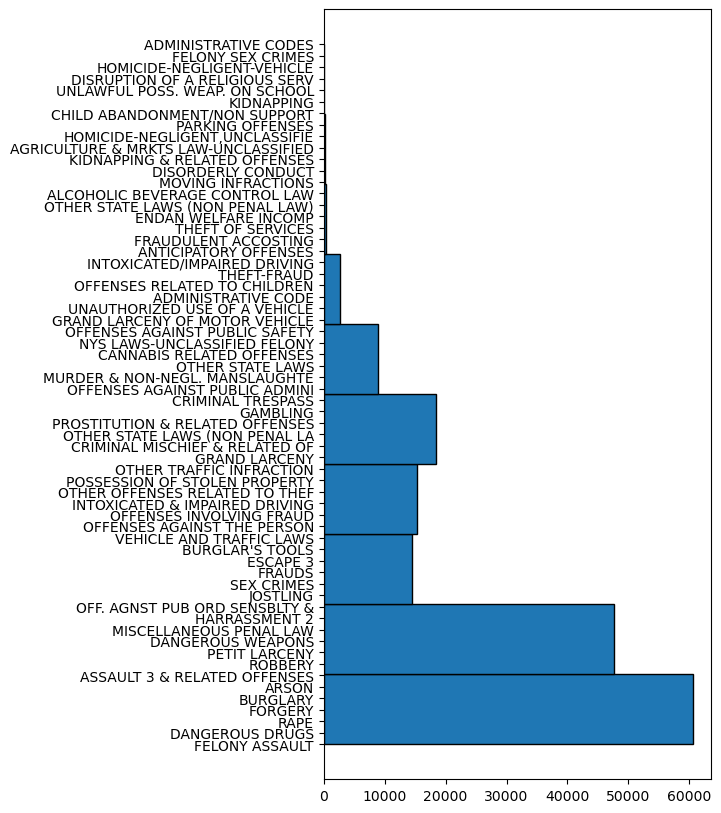

In [13]:
#| echo: true 
#| code-fold: true

plt.figure(figsize=(5,10))
plt.hist(safe_geo['ofns_desc'],  orientation='horizontal', edgecolor='black')

### 1.3 Get the census tract data
And besides the public safety, We assume that the population, household income, labor force, traffic time will also have effect on sale price, so we decide to get the data relate to those topic.

In [14]:
# get the census tract data available
import cenpy

available = cenpy.explorer.available()

C:\Users\zhaiy\mambaforge\envs\musa-550-fall-2023\lib\site-packages\libpysal\cg\alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
C:\Users\zhaiy\mambaforge\envs\musa-550-fall-2023\lib\site-packages\libpysal\cg\alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
C:\Users\zhaiy\mambaforge\e

In [15]:
#we will use the data from 2020, by American Community Survey estimates
acs = cenpy.remote.APIConnection("ACSDP5Y2020")

#explore the data profile included in this database 
acs.variables.head()

label  \
for                               Census API FIPS 'for' clause   
in                                 Census API FIPS 'in' clause   
ucgid               Uniform Census Geography Identifier clause   
DP02_0126E          Estimate!!ANCESTRY!!Total population!!Arab   
DP05_0050PE  Percent!!RACE!!Total population!!One race!!Asi...   

                                                       concept predicateType  \
for                         Census API Geography Specification      fips-for   
in                          Census API Geography Specification       fips-in   
ucgid                       Census API Geography Specification         ucgid   
DP02_0126E   SELECTED SOCIAL CHARACTERISTICS IN THE UNITED ...           int   
DP05_0050PE              ACS DEMOGRAPHIC AND HOUSING ESTIMATES         float   

            group limit predicateOnly hasGeoCollectionSupport  \
for           N/A     0          True                     NaN   
in            N/A     0          True                     NaN   
ucgid         N/A     0          True                    True   
DP02_0126E   DP02     0           NaN                     NaN   
DP05_0050PE  DP05     0           NaN                     NaN   

                                        attributes required  
for                                            NaN      NaN  
in                                             NaN      NaN  
ucgid                                          NaN      NaN  
DP02_0126E      DP02_0126EA,DP02_0126M,DP02_0126MA      NaN  
DP05_0050PE  DP05_0050PEA,DP05_0050PM,DP05_0050PMA      NaN

In [16]:
#| echo: true 
#| code-fold: true

pd.options.display.max_rows = 9999 
pd.options.display.max_colwidth = 200

In [17]:
variables = [
   "NAME",
   "DP05_0001E", #Total population
   "DP05_0086E", #Total Housing Units
   "DP03_0002E", #In Labor Force
   "DP03_0025E", #Mean travel time to work (minutes)
   "DP03_0062E", #Median household income (dollars)
   "DP02_0001E", #Total households
]

**Tips**

New York City is composed of 5 boroughs, with each borough also its own county. Manhattan is in New York County, Brooklyn is in Kings County, Queens is in Queens County, the Bronx is in Bronx County, and Staten Island is in Richmond County. The counties and boroughs of New York City are coterminous.

In [18]:
# First, get the NY County Data.
nyc_demo_data = acs.query(
    cols=variables,
    geo_unit="tract:*",
    geo_filter={"state": "36", "county": "061"},
)

In [19]:
# Then, Get the data from 4 other Counties
counties = [('36', '005'),('36','047'),('36','081'),('36','085')]  # Replace with actual FIPS codes

for state, county in counties:
    new_data = acs.query(cols=variables, geo_unit='tract', geo_filter={'state': state, 'county': county})
    nyc_demo_data = nyc_demo_data.append(new_data, ignore_index=True)

C:\Users\zhaiy\AppData\Local\Temp\ipykernel_8424\2929721321.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nyc_demo_data = nyc_demo_data.append(new_data, ignore_index=True)
C:\Users\zhaiy\AppData\Local\Temp\ipykernel_8424\2929721321.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nyc_demo_data = nyc_demo_data.append(new_data, ignore_index=True)
C:\Users\zhaiy\AppData\Local\Temp\ipykernel_8424\2929721321.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nyc_demo_data = nyc_demo_data.append(new_data, ignore_index=True)
C:\Users\zhaiy\AppData\Local\Temp\ipykernel_8424\2929721321.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [20]:
# Rename the data to our topic
nyc_census = nyc_demo_data.rename(columns={"DP05_0001E": "Total_Population",
                              "DP05_0086E": "Total Housing Units",
                              "DP03_0002E":"In Labor Force",
                              "DP03_0025E":"Travel_Time", 
                              "DP03_0062E":"Median_HH_Income",
                              "DP02_0001E":"Total_HH"})

nyc_census['GEOID'] = nyc_census['state'] + nyc_census['county'] + nyc_census['tract']
nyc_census.head()

NAME Total_Population  \
0  Census Tract 165, New York County, New York             6674   
1  Census Tract 166, New York County, New York             6002   
2  Census Tract 167, New York County, New York             6058   
3  Census Tract 168, New York County, New York             5189   
4  Census Tract 169, New York County, New York             8272   

  Total Housing Units In Labor Force Travel_Time Median_HH_Income Total_HH  \
0                3841           3954        32.9           184691     3176   
1                3279           2953        33.0            47778     2796   
2                3804           3616        30.6           203711     2969   
3                2102           1561        44.3            27222     1774   
4                5016           5033        31.0           131097     3949   

  state county   tract        GEOID  
0    36    061  016500  36061016500  
1    36    061  016600  36061016600  
2    36    061  016700  36061016700  
3    36    061  016800  36061016800  
4    36    061  016900  36061016900

In [21]:
len(nyc_census) # We have 2327 Census Tracts in total.

2327

In [22]:
#| echo: true 
#| code-fold: true

# Then we will get the polygon of our census tracts in order to merge data with values
import pygris

In [23]:
nyc_tracts = pygris.tracts(
    state="36", county="061", year=2020
)

for state, county in counties:
    new_tracts = pygris.tracts(
    state=state, county=county, year=2020
)
    nyc_tracts = nyc_tracts.append(new_tracts, ignore_index=True)

C:\Users\zhaiy\AppData\Local\Temp\ipykernel_8424\405300660.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nyc_tracts = nyc_tracts.append(new_tracts, ignore_index=True)
C:\Users\zhaiy\AppData\Local\Temp\ipykernel_8424\405300660.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nyc_tracts = nyc_tracts.append(new_tracts, ignore_index=True)
C:\Users\zhaiy\AppData\Local\Temp\ipykernel_8424\405300660.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nyc_tracts = nyc_tracts.append(new_tracts, ignore_index=True)
C:\Users\zhaiy\AppData\Local\Temp\ipykernel_8424\405300660.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nyc_tracts = n

In [24]:
nyc_tracts.head()

STATEFP COUNTYFP TRACTCE        GEOID   NAME            NAMELSAD  MTFCC  \
0      36      061  001501  36061001501  15.01  Census Tract 15.01  G5020   
1      36      061  001600  36061001600     16     Census Tract 16  G5020   
2      36      061  001800  36061001800     18     Census Tract 18  G5020   
3      36      061  002000  36061002000     20     Census Tract 20  G5020   
4      36      061  002201  36061002201  22.01  Census Tract 22.01  G5020   

  FUNCSTAT   ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  270812  166085  +40.7075653  -074.0013991   
1        S  207381       0  +40.7159568  -073.9932660   
2        S  222964       0  +40.7190464  -073.9908407   
3        S  126280  137883  +40.7206299  -073.9750259   
4        S  161668       0  +40.7191156  -073.9818443   

                                                                                                                                                                                                  geometry  
0  POLYGON ((-74.00860 40.71139, -74.00835 40.71136, -74.00797 40.71145, -74.00809 40.71146, -74.00815 40.71148, -74.00820 40.71149, -74.00822 40.71152, -74.00823 40.71155, -74.00822 40.71158, -74.00...  
1  POLYGON ((-73.99750 40.71407, -73.99709 40.71462, -73.99681 40.71504, -73.99653 40.71547, -73.99606 40.71623, -73.99543 40.71728, -73.99481 40.71846, -73.99383 40.71814, -73.99309 40.71792, -73.99...  
2  POLYGON ((-73.99442 40.71939, -73.99438 40.71952, -73.99426 40.71978, -73.99403 40.72032, -73.99379 40.72094, -73.99367 40.72126, -73.99352 40.72163, -73.99273 40.72140, -73.99224 40.72125, -73.99...  
3  POLYGON ((-73.97872 40.71998, -73.97823 40.72067, -73.97802 40.72097, -73.97779 40.72128, -73.97768 40.72142, -73.97736 40.72186, -73.97735 40.72189, -73.97689 40.72250, -73.97616 40.72219, -73.97...  
4  POLYGON ((-73.98448 40.72023, -73.98382 40.72147, -73.98300 40.72122, -73.98217 40.72097, -73.98131 40.72071, -73.97973 40.72023, -73.97875 40.71993, -73.97904 40.71939, -73.97942 40.71867, -73.97...

## Part 2: Spatial join the data to the census tract.
And take a look at the median housing price of different census tract.

In [26]:
merged_ct = pd.merge(nyc_tracts, nyc_census, on='GEOID', how='left')
merged_ct.head()

STATEFP COUNTYFP TRACTCE        GEOID NAME_x            NAMELSAD  MTFCC  \
0      36      061  001501  36061001501  15.01  Census Tract 15.01  G5020   
1      36      061  001600  36061001600     16     Census Tract 16  G5020   
2      36      061  001800  36061001800     18     Census Tract 18  G5020   
3      36      061  002000  36061002000     20     Census Tract 20  G5020   
4      36      061  002201  36061002201  22.01  Census Tract 22.01  G5020   

  FUNCSTAT   ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  270812  166085  +40.7075653  -074.0013991   
1        S  207381       0  +40.7159568  -073.9932660   
2        S  222964       0  +40.7190464  -073.9908407   
3        S  126280  137883  +40.7206299  -073.9750259   
4        S  161668       0  +40.7191156  -073.9818443   

                                                                                                                                                                                                  geometry  \
0  POLYGON ((-74.00860 40.71139, -74.00835 40.71136, -74.00797 40.71145, -74.00809 40.71146, -74.00815 40.71148, -74.00820 40.71149, -74.00822 40.71152, -74.00823 40.71155, -74.00822 40.71158, -74.00...   
1  POLYGON ((-73.99750 40.71407, -73.99709 40.71462, -73.99681 40.71504, -73.99653 40.71547, -73.99606 40.71623, -73.99543 40.71728, -73.99481 40.71846, -73.99383 40.71814, -73.99309 40.71792, -73.99...   
2  POLYGON ((-73.99442 40.71939, -73.99438 40.71952, -73.99426 40.71978, -73.99403 40.72032, -73.99379 40.72094, -73.99367 40.72126, -73.99352 40.72163, -73.99273 40.72140, -73.99224 40.72125, -73.99...   
3  POLYGON ((-73.97872 40.71998, -73.97823 40.72067, -73.97802 40.72097, -73.97779 40.72128, -73.97768 40.72142, -73.97736 40.72186, -73.97735 40.72189, -73.97689 40.72250, -73.97616 40.72219, -73.97...   
4  POLYGON ((-73.98448 40.72023, -73.98382 40.72147, -73.98300 40.72122, -73.98217 40.72097, -73.98131 40.72071, -73.97973 40.72023, -73.97875 40.71993, -73.97904 40.71939, -73.97942 40.71867, -73.97...   

                                          NAME_y Total_Population  \
0  Census Tract 15.01, New York County, New York             8021   
1     Census Tract 16, New York County, New York             7504   
2     Census Tract 18, New York County, New York             7101   
3     Census Tract 20, New York County, New York             4606   
4  Census Tract 22.01, New York County, New York             6372   

  Total Housing Units In Labor Force Travel_Time Median_HH_Income Total_HH  \
0                4266           4352        25.5           103102     3720   
1                3448           4271        31.0            60975     3147   
2                3383           3800        28.0            51480     3095   
3                2040           1302        37.7            18750     1964   
4                3165           2759        35.7            25188     2988   

  state county   tract  
0    36    061  001501  
1    36    061  001600  
2    36    061  001800  
3    36    061  002000  
4    36    061  002201

In [27]:
len(merged_ct)

2327

Explore the data by using a interactive map!

In [28]:
#| echo: true 
#| code-fold: true

merged_ct.explore("Median_HH_Income")

In [29]:
#| echo: true 
#| code-fold: true

merged_ct = merged_ct.to_crs(epsg='4326')

In [30]:
safe_merged = gpd.sjoin(merged_ct, safe_geo, how='left', op='intersects')
safe_merged.head()

C:\Users\zhaiy\mambaforge\envs\musa-550-fall-2023\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


STATEFP COUNTYFP TRACTCE        GEOID NAME_x            NAMELSAD  MTFCC  \
0      36      061  001501  36061001501  15.01  Census Tract 15.01  G5020   
0      36      061  001501  36061001501  15.01  Census Tract 15.01  G5020   
0      36      061  001501  36061001501  15.01  Census Tract 15.01  G5020   
0      36      061  001501  36061001501  15.01  Census Tract 15.01  G5020   
0      36      061  001501  36061001501  15.01  Census Tract 15.01  G5020   

  FUNCSTAT   ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  270812  166085  +40.7075653  -074.0013991   
0        S  270812  166085  +40.7075653  -074.0013991   
0        S  270812  166085  +40.7075653  -074.0013991   
0        S  270812  166085  +40.7075653  -074.0013991   
0        S  270812  166085  +40.7075653  -074.0013991   

                                                                                                                                                                                                  geometry  \
0  POLYGON ((-74.00860 40.71139, -74.00835 40.71136, -74.00797 40.71145, -74.00809 40.71146, -74.00815 40.71148, -74.00820 40.71149, -74.00822 40.71152, -74.00823 40.71155, -74.00822 40.71158, -74.00...   
0  POLYGON ((-74.00860 40.71139, -74.00835 40.71136, -74.00797 40.71145, -74.00809 40.71146, -74.00815 40.71148, -74.00820 40.71149, -74.00822 40.71152, -74.00823 40.71155, -74.00822 40.71158, -74.00...   
0  POLYGON ((-74.00860 40.71139, -74.00835 40.71136, -74.00797 40.71145, -74.00809 40.71146, -74.00815 40.71148, -74.00820 40.71149, -74.00822 40.71152, -74.00823 40.71155, -74.00822 40.71158, -74.00...   
0  POLYGON ((-74.00860 40.71139, -74.00835 40.71136, -74.00797 40.71145, -74.00809 40.71146, -74.00815 40.71148, -74.00820 40.71149, -74.00822 40.71152, -74.00823 40.71155, -74.00822 40.71158, -74.00...   
0  POLYGON ((-74.00860 40.71139, -74.00835 40.71136, -74.00797 40.71145, -74.00809 40.71146, -74.00815 40.71148, -74.00820 40.71149, -74.00822 40.71152, -74.00823 40.71155, -74.00822 40.71158, -74.00...   

                                          NAME_y Total_Population  \
0  Census Tract 15.01, New York County, New York             8021   
0  Census Tract 15.01, New York County, New York             8021   
0  Census Tract 15.01, New York County, New York             8021   
0  Census Tract 15.01, New York County, New York             8021   
0  Census Tract 15.01, New York County, New York             8021   

  Total Housing Units In Labor Force Travel_Time Median_HH_Income Total_HH  \
0                4266           4352        25.5           103102     3720   
0                4266           4352        25.5           103102     3720   
0                4266           4352        25.5           103102     3720   
0                4266           4352        25.5           103102     3720   
0                4266           4352        25.5           103102     3720   

  state county   tract  index_right arrest_key              arrest_date pd_cd  \
0    36    061  001501     114437.0  273573301  2023-08-28T00:00:00.000   494   
0    36    061  001501      71325.0  268056743  2023-05-10T00:00:00.000   109   
0    36    061  001501      60714.0  263536626  2023-02-13T00:00:00.000   339   
0    36    061  001501       6811.0  266496509  2023-04-11T00:00:00.000   109   
0    36    061  001501      69172.0  271435118  2023-07-17T00:00:00.000   339   

                          pd_desc ky_cd                      ofns_desc  \
0  STOLEN PROPERTY 2,1,POSSESSION   111  POSSESSION OF STOLEN PROPERTY   
0        ASSAULT 2,1,UNCLASSIFIED   106                 FELONY ASSAULT   
0  LARCENY,PETIT FROM OPEN AREAS,   341                  PETIT LARCENY   
0        ASSAULT 2,1,UNCLASSIFIED   106                 FELONY ASSAULT   
0  LARCENY,PETIT FROM OPEN AREAS,   341                  PETIT LARCENY   

     law_code law_cat_cd arrest_boro arrest_precinct jurisdiction_code  \
0  PL 1654501          F           M               1                 

In [31]:
count_values = safe_merged.groupby('GEOID')['ofns_desc'].count()

merged_ct = merged_ct.merge(count_values, left_on='GEOID', right_index=True)

In [32]:
sales_census = gpd.sjoin(prosal_last_geo, merged_ct, how='left', op='intersects').drop(columns = ['index_right'])
sales_census.head()

C:\Users\zhaiy\mambaforge\envs\musa-550-fall-2023\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


borough neighborhood building_class_category tax_class_as_of_final_roll  \
5        1      CHELSEA     21 OFFICE BUILDINGS                          4   
6        1      CHELSEA     21 OFFICE BUILDINGS                          4   
8        1      CHELSEA      22 STORE BUILDINGS                          4   
11       1      CHELSEA       23 LOFT BUILDINGS                          4   
14       1      CHELSEA           30 WAREHOUSES                          4   

   block lot building_class_as_of_final                     address zip_code  \
5    802  75                         O6          158 WEST 27 STREET    10001   
6    803   4                         O4                307 7 AVENUE    10001   
8    772  72                         K7        250 WEST 23RD STREET    10011   
11   799  67                         L1  148 WEST 24TH STREET, 4 FL    10011   
14   794   9                         E9        157 WEST 18TH STREET    10011   

   residential_units commercial_units total_units land_square_feet  \
5                  0               14          14            8,305   
6                  0              194         194           10,225   
8                  0                1           1            4,938   
11                 0               15          15            4,937   
14                 0                1           1            3,620   

    gross_square_feet year_built tax_class_at_time_of_sale  \
5            108000.0       1913                         4   
6            197612.0       1926                         4   
8             15716.0       1948                         4   
11            55923.0       1910                         4   
14            23800.0       1906                         4   

   building_class_at_time_of   sale_price                sale_date   latitude  \
5                         O6   99350000.0  2019-10-24T00:00:00.000  40.746089   
6                         O4  115000000.0  2019-10-17T00:00:00.000  40.746869   
8                         K7   14500000.0  2019-09-05T00:00:00.000  40.744698   
11                        L1    4500000.0  2019-02-28T00:00:00.000  40.744149   
14                        E9   23200000.0  2019-02-20T00:00:00.000  40.740526   

     longitude community_board council_district census_tract      bin  \
5   -73.992576             105                3           95  1015055   
6   -73.993616             105                3           95  1015061   
8   -73.997091             104                3           91  1014135   
11  -73.993721             104                3           91  1014966   
14  -73.996575             104                3           87  1014713   

           bbl                                         nta  \
5   1008020075                       Midtown-Midtown South   
6   1008030004                       Midtown-Midtown South   
8   1007720072  Hudson Yards-Chelsea-Flatiron-Union Square   
11  1007990067  Hudson Yards-Chelsea-Flatiron-Union Square   
14  1007940009  Hudson Yards-Chelsea-Flatiron-Union Square   

                      geometry  unit_sale_price STATEFP COUNTYFP TRACTCE  \
5   POINT (-73.99258 40.74609)       919.907407      36      061  009500   
6   POINT (-73.99362 40.74687)       581.948465      36      061  009500   
8   POINT (-73.99709 40.74470)       922.626623      36      061  009100   
11  POINT (-73.99372 40.74415)        80.467786      36      061  009100   
14  POINT (-73.99658 40.74053)       974.789916      36      061  008700   

          GEOID NAME_x         NAMELSAD  MTFCC FUNCSTAT     ALAND  AWATER  \
5   36061009500     95  Census Tract 95  G5020        S  171964.0     0.0   
6   36061009500     95  Census Tract 95  G5020        S  171964.0     0.0   
8   36061009100     91  Census Tract 91  G5020        S  179098.0     0.0   
11  36061009100     91  Census Tract 91  G5020        S  179098.0     0.0   
14  36061008700     87  Census Tract 87  G5020        S  165443.0     0.0   

       INTPTLAT      INTPTLON           

In [33]:
sales_census = sales_census.dropna()
len(sales_census)

162879

## Part 3: SKlearn Train a Random Forest on Property Sales

Then, We get all the data we need to train a predict model, we can start training right now!

In [34]:
#| echo: true 
#| code-fold: true

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Pipelines
from sklearn.pipeline import make_pipeline

# Preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

### 3.1 set a pipeline include all variables

In [35]:
#| echo: true 
#| code-fold: true

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [93]:
# Numerical columns
num_cols = [
    "Total_Population",
    "Total Housing Units",
    "In Labor Force",
    "Travel_Time",
    "Median_HH_Income",
    "Total_HH",
    "ofns_desc",
]

# Categorical columns
cat_cols = [
    "building_class_category", 
]

In [94]:
# Set up the column transformer with two transformers
# ----> Scale the numerical columns
# ----> One-hot encode the categorical columns

transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

In [95]:
# Initialize the pipeline
# NOTE: only use 20 estimators here so it will run in a reasonable time
pipe = make_pipeline(
    transformer, RandomForestRegressor(n_estimators=20, random_state=42)
)

### 3.2 Split 30% & 70%

In [96]:
# Split the data 70/30
train_set, test_set = train_test_split(sales_census, 
                                       test_size=0.3, 
                                       random_state=42)

# the target labels: log of sale price
y_train = np.log(train_set["unit_sale_price"])
y_test = np.log(test_set["unit_sale_price"])
x_train = train_set[
   [ "Total_Population",
    "Total Housing Units",
    "In Labor Force",
    "Travel_Time",
    "Median_HH_Income",
    "Total_HH",
    "ofns_desc",
    "building_class_category",]
]
x_test = test_set[
   ["Total_Population",
    "Total Housing Units",
    "In Labor Force",
    "Travel_Time",
    "Median_HH_Income",
    "Total_HH",
    "ofns_desc",
    "building_class_category",]
]

In [97]:
# Fit the training set
pipe.fit(train_set, y_train);

In [98]:
# What's the test score?
pipe.score(test_set, y_test)

0.4906609622139816

### 3.3 Use GridSearchCV to perform a k-fold cross validation that optimize at least 2 hyperparameters of the RandomForestRegressor.

In [99]:
from sklearn.model_selection import GridSearchCV

In [100]:
from sklearn.pipeline import Pipeline
# Create our regression pipeline
pipe2 = Pipeline(steps=[('preprocessor', transformer),
                              ('regressor', RandomForestRegressor())])
pipe2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Total_Population',
                                                   'Total Housing Units',
                                                   'In Labor Force',
                                                   'Travel_Time',
                                                   'Median_HH_Income',
                                                   'Total_HH', 'ofns_desc']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['building_class_category'])])),
                ('regressor', RandomForestRegressor())])

In [101]:
pipe2.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num', StandardScaler(),
                                  ['Total_Population', 'Total Housing Units',
                                   'In Labor Force', 'Travel_Time',
                                   'Median_HH_Income', 'Total_HH',
                                   'ofns_desc']),
                                 ('cat', OneHotEncoder(handle_unknown='ignore'),
                                  ['building_class_category'])]),
 'regressor': RandomForestRegressor()}

In [102]:
param_grid = {
    'regressor__n_estimators': [100, 200, 300],  
    'regressor__max_depth': [None, 10, 20, 30],  
    
}
param_grid

{'regressor__n_estimators': [100, 200, 300],
 'regressor__max_depth': [None, 10, 20, 30]}

In [103]:
grid_search = GridSearchCV(pipe2, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Total_Population',
                                                                          'Total '
                                                                          'Housing '
                                                                          'Units',
                                                                          'In '
                                                                          'Labor '
                                                                          'Force',
                                                                          'Travel_Time',
                                                                          'Median_HH_Income',
                                                                          'Total_HH',
                                                                          'ofns_desc']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['building_class_category'])])),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 10, 20, 30],
                         'regressor__n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=2)

In [104]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Total_Population',
                                                   'Total Housing Units',
                                                   'In Labor Force',
                                                   'Travel_Time',
                                                   'Median_HH_Income',
                                                   'Total_HH', 'ofns_desc']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['building_class_category'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=30, n_estimators=300))])

In [105]:
grid_search.best_params_

{'regressor__max_depth': 30, 'regressor__n_estimators': 300}

In [106]:
def evaluate_mape(model, X_test, y_test):
    """
    Given a model and test features/targets, print out the 
    mean absolute error and accuracy
    """
    # Make the predictions
    predictions = model.predict(X_test)

    # Absolute error
    errors = abs(predictions - y_test)
    avg_error = np.mean(errors)

    # Mean absolute percentage error
    mape = 100 * np.mean(errors / y_test)

    # Accuracy
    accuracy = 100 - mape

    print("Model Performance")
    print(f"Average Absolute Error: {avg_error:0.4f}")
    print(f"Accuracy = {accuracy:0.2f}%.")

    return accuracy

In [107]:
# Initialize the pipeline
base_model = make_pipeline(
    transformer, RandomForestRegressor(n_estimators=20, random_state=42)
)

# Fit the training set
base_model.fit(x_train, y_train)

# Evaluate on the test set
base_accuracy = evaluate_mape(base_model, x_test, y_test)# Initialize the pipeline

Model Performance
Average Absolute Error: 0.3403
Accuracy = 93.23%.


In [108]:
# Initialize the pipeline
best_model = grid_search.best_estimator_

# Fit the training set
best_model.fit(x_train, y_train)

# Evaluate on the test set
best_accuracy = evaluate_mape(best_model, x_test, y_test)

Model Performance
Average Absolute Error: 0.3354
Accuracy = 93.31%.


#### Errors:
we first test the model on the 0.3 split of 2020 data and received a test score of 0.49. This score is good enough for us to proceed with this model. For the model on historical data of 2020, we achieved an accuracy of 93.23%; whereas for the trained model, we achieved an accuracy of 93.31%. We then calculated the percentage error for each census tract and created a choropleth map to see the spatial distribution of errors. It can be seen that the error level is consistently low across most of the areas, except two or three areas as outliners. This means that our model is relatively spatially consistent. 

### 3.4 Make a data frame with percent errors and census tract info for each sale in the test set
Create a data frame that has the property geometries, census tract data, and percent errors for all of the sales in the test set.

In [109]:
predictions = best_model.predict(x_test)

# Absolute error
errors =  abs((y_test - predictions) / y_test) * 100
errors.head()

282469    0.116377
287738    7.274291
328679    0.732932
218207    3.038824
63011     3.530113
Name: unit_sale_price, dtype: float64

In [111]:
test_set['percent_error'] = errors
test_set.head()

borough        neighborhood     building_class_category  \
282469       3  BEDFORD STUYVESANT  03  THREE FAMILY DWELLINGS   
287738       4            ROSEDALE    01  ONE FAMILY DWELLINGS   
328679       2          BAYCHESTER    01  ONE FAMILY DWELLINGS   
218207  QUEENS        FAR ROCKAWAY     02 TWO FAMILY DWELLINGS   
63011        4             MASPETH     02 TWO FAMILY DWELLINGS   

       tax_class_as_of_final_roll  block  lot building_class_as_of_final  \
282469                          1   1807   82                         C0   
287738                          1  13750  176                         A2   
328679                          1   4780   46                         A5   
218207                          1  15790   27                         B3   
63011                           1   2779   44                         B2   

                       address zip_code residential_units commercial_units  \
282469           363 GATES AVE    11216                 3                0   
287738  147-63 EDGEWOOD STREET    11422                 1                0   
328679         3020 ELY AVENUE    10469                 1                0   
218207     414 BEACH 27 STREET    11691                 2                0   
63011         68-07 59TH DRIVE    11378                 2                0   

       total_units land_square_feet  gross_square_feet year_built  \
282469           3            2,000             2880.0       1899   
287738           1            5,200             1369.0       1955   
328679           1            2,651             1260.0       1960   
218207           2            3,600             1768.0       1920   
63011            2            2,000             1836.0       1931   

       tax_class_at_time_of_sale building_class_at_time_of  sale_price  \
282469                         1                        C0   1150000.0   
287738                         1                        A2    276500.0   
328679                         1                        A5    320000.0   
218207                         1                        B3    350000.0   
63011                          1                        B2    965000.0   

                      sale_date   latitude   longitude community_board  \
282469  2016-05-10T00:00:00.000  40.685994  -73.952625             303   
287738  2016-05-31T00:00:00.000   40.65567  -73.741928             413   
328679  2016-11-10T00:00:00.000  40.871916  -73.836824             212   
218207  2021-03-05T00:00:00.000   40.59785  -73.760714             414   
63011   2019-09-25T00:00:00.000  40.721695  -73.893983             405   

       council_district census_tract      bin         bbl  \
282469               36          243  3050859  3018070082   
287738               31          664  4292017  4137500176   
328679               12        46202  2062294  2047800046   
218207               31        99801  4301435  4157900027   
63011                30        66701  4062280  4027790044   

                           nta                    geometry  unit_sale_price  \
282469                 Bedford  POINT (-73.95262 40.68599)       399.305556   
287738                Rosedale  POINT (-73.74193 40.65567)       201.972243   
328679              Co-op City  POINT (-73.83682 40.87192)       253.968254   
218207  Far Rockaway-Bayswater  POINT (-73.76071 40.59785)       197.963801   
63011           Middle Village  POINT (-73.89398 40.72169)       525.599129   

       STATEFP COUNTYFP TRACTCE        GEOID  NAME_x             NAMELSAD  \
282469      36      047  024300  36047024300     243     Census Tract 243   
287738      36      081  066401  36081066401  664.01  Census Tract 664.01   
328679      36      005  046208  36005046208  462.08  Census Tract 462.08   
218207      36      081  099801  36081099801  998.01  Census Tract 998.01   
63011       36      081  066701  36081066701  667.01  Census Tract 667.01   

        MTFCC FUNCSTAT      ALAND    AWATER     INTPTLAT      INTPTLON  \


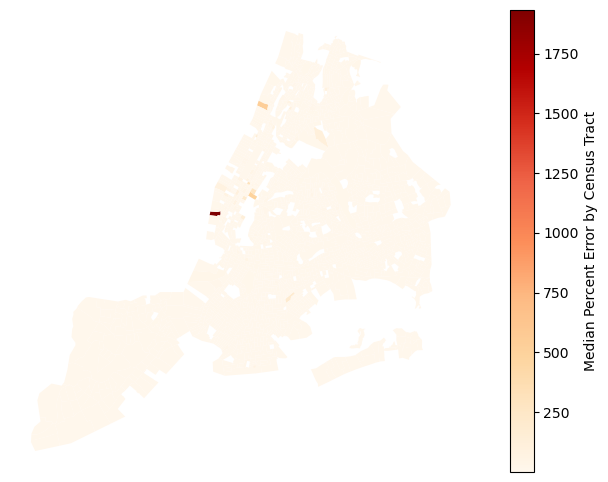

In [113]:
median_errors = test_set.groupby('GEOID')['percent_error'].median().reset_index()

error_map = merged_ct.merge(median_errors, on='GEOID')

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
error_map.plot(column='percent_error', ax=ax, legend=True,
               legend_kwds={'label': "Median Percent Error by Census Tract"},
               cmap='OrRd')  # Choose a colormap that fits your data and preference
ax.set_axis_off()